到目前为止，我们遇到过两种类型的数据：**表格数据**和**图像数据**。 对于图像数据，我们设计了专门的卷积神经网络架构来为这类特殊的数据结构建模。 换句话说，如果我们拥有一张图像，我们需要有效地利用其像素位置，假若我们对图像中的像素位置进行重排，就会对图像中内容的推断造成极大的困难。


最重要的是，到目前为止我们默认数据都来自于某种分布， 并且所有样本都是独立同分布的 （independently and identically distributed，i.i.d.）。 然而，大多数的数据并非如此。 例如，文章中的单词是按顺序写的，如果顺序被随机地重排，就很难理解文章原始的意思。 同样，视频中的图像帧、对话中的音频信号以及网站上的浏览行为都是有顺序的。 因此，针对此类数据而设计特定模型，可能效果会更好。


另一个问题来自这样一个事实： 我们不仅仅可以接收一个序列作为输入，而是还可能期望继续猜测这个序列的后续。 例如，一个任务可以是继续预测2,4,6,8,10...。 这在时间序列分析中是相当常见的，可以用来预测股市的波动、患者的体温曲线或者赛车所需的加速度。同理，我们需要能够处理这些数据的特定模型。


简言之，如果说**卷积神经网络可以有效地处理空间信息**，那么本章的循环神经网络（recurrent neural network，RNN）则可以更好地处理序列信息。循环神经网络通过引入**状态变量**存储过去的信息和当前的输入，从而可以确定当前的输出。


许多使用循环网络的例子都是基于文本数据的，因此我们将在本章中重点介绍语言模型。在对序列数据进行更详细的回顾之后，我们将介绍文本预处理的实用技术。然后，我们将讨论语言模型的基本概念，并将此讨论作为循环神经网络设计的灵感。最后，我们描述了循环神经网络的梯度计算方法，以探讨训练此类网络时可能遇到的问题。

# 8.1. 序列模型
序列数据的场景：
1. 电影评分
2. 在使用应用程序时，许多用户都有很强的特定习惯。例如，在学生放学后社交媒体应用更受欢迎。在市场开放时股市交易软件更常用。
3. 预测明天的股价要比过去的股价更困难，尽管两者都只是估计一个数字。毕竟，先见之明比事后诸葛亮难得多。在统计学中，前者（对超出已知观测范围进行预测）称为外推法（extrapolation），而后者（在现有观测值之间进行估计）称为内插法（interpolation）。
4. 在本质上，音乐、语音、文本和视频都是连续的。如果它们的序列被我们重排，那么就会失去原有的意义。比如，一个文本标题“狗咬人”远没有“人咬狗”那么令人惊讶，尽管组成两句话的字完全相同。
5. 地震具有很强的相关性，即大地震发生后，很可能会有几次小余震，这些余震的强度比非大地震后的余震要大得多。事实上，地震是时空相关的，即余震通常发生在很短的时间跨度和很近的距离内。
6. 人类之间的互动也是连续的，这可以从微博上的争吵和辩论中看出。

## 8.1.1. 统计工具

![](../img/8_1.png)

### 自回归模型
如何有效估计$P(x_t \mid x_{t-1}, \ldots, x_1)$，归结于以下两种策略：

第一种策略，**对见过的数据建模，使用自身过去数据来预测未来**，假设在现实情况下相当长的序列$x_{t-1}, \ldots, x_1$可能是不必要的，因此我们只需要满足某个长度为$\tau$的时间跨度，即使用观测序列$x_{t-1}, \ldots, x_{t-\tau}$。当下获得的最直接的好处就是参数的数量总是不变的，至少在$t > \tau$时如此，这就使我们能够训练一个上面提及的深度网络。这种模型被称为**自回归模型**（autoregressive models），因为它们是对自己执行回归。


第二种策略，**潜变量模型，使用潜变量来概括历史信息**，如下图所示，是保留一些对过去观测的总结$h_t$，并且同时更新预测$\hat{x}_t$和总结$h_t$。这就产生了基于$\hat{x}_t = P(x_t \mid h_{t})$估计$x_t$，以及公式$h_t = g(h_{t-1}, x_{t-1})$更新的模型。由于$h_t$从未被观测到，这类模型也被称为**隐变量自回归模型**（latent autoregressive models）。

![](../img/8_2.png)

![](../img/8_10.png)


这两种情况都有一个显而易见的问题：如何生成训练数据？一个经典方法是使用历史观测来预测下一个未来观测。显然，我们并不指望时间会停滞不前。然而，一个常见的假设是虽然特定值$x_t$可能会改变，但是序列本身的动力学不会改变。这样的假设是合理的，因为新的动力学一定受新的数据影响，而我们不可能用目前所掌握的数据来预测新的动力学。统计学家称不变的动力学为**静止的**（stationary）。因此，整个序列的估计值都将通过以下的方式获得：

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1).$$

注意，如果我们处理的是离散的对象（如单词），而不是连续的数字，则上述的考虑仍然有效。唯一的差别是，对于离散的对象，我们需要使用分类器而不是回归模型来估计$P(x_t \mid  x_{t-1}, \ldots, x_1)$。


### 马尔可夫模型
**假设当前数据只跟$\tau$个过去数据点相关，从而简化模型**。回想一下，在自回归模型的近似法中，我们使用$x_{t-1}, \ldots, x_{t-\tau}$而不是$x_{t-1}, \ldots, x_1$来估计$x_t$。只要这种是近似精确的，我们就说序列满足**马尔可夫条件**（Markov condition）。特别是，如果$\tau = 1$，得到一个**一阶马尔可夫模型**（first-order Markov model），$P(x)$由下式给出：

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ 当 } P(x_1 \mid x_0) = P(x_1).$$

当假设$x_t$仅是离散值时，这样的模型特别棒，因为在这种情况下，使用动态规划可以沿着马尔可夫链精确地计算结果。例如，我们可以高效地计算$P(x_{t+1} \mid x_{t-1})$：

$$
\begin{aligned}
P(x_{t+1} \mid x_{t-1}) &= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})}
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})}
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{aligned}
$$

利用这一事实，我们只需要考虑过去观察中的一个非常短的历史：$P(x_{t+1} \mid x_t, x_{t-1}) = P(x_{t+1} \mid x_t)$。隐马尔可夫模型中的动态规划超出了本节的范围（我们将在9.4再次遇到），而动态规划这些计算工具已经在控制算法和强化学习算法广泛使用。


### 因果关系
原则上，将$P(x_1, \ldots, x_T)$倒序展开也没什么问题。毕竟，基于条件概率公式，我们总是可以写出：

$$P(x_1, \ldots, x_T) = \prod_{t=T}^1 P(x_t \mid x_{t+1}, \ldots, x_T).$$

事实上，如果基于一个马尔可夫模型，我们还可以得到一个反向的条件概率分布。然而，在许多情况下，数据存在一个自然的方向，即在时间上是前进的。很明显，未来的事件不能影响过去。因此，如果我们改变$x_t$，可能会影响未来发生的事情$x_{t+1}$，但不能反过来。也就是说，如果我们改变$x_t$，基于过去事件得到的分布不会改变。因此，解释$P(x_{t+1} \mid x_t)$应该比解释$P(x_t \mid x_{t+1})$更容易。例如，在某些情况下，对于某些可加性噪声$\epsilon$，显然我们可以找到$x_{t+1} = f(x_t) + \epsilon$，而反之则不行。而这个向前推进的方向恰好也是我们通常感兴趣的方向。彼得斯等人 :cite:`Peters.Janzing.Scholkopf.2017`对该主题的更多内容做了详尽的解释，而我们的上述讨论只是其中的冰山一角。


## 8.1.2. 训练
使用马尔科夫假设来训练mlp

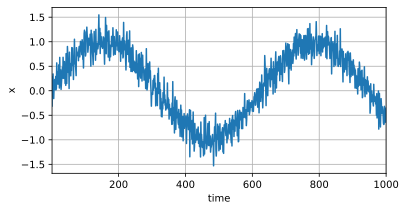

In [2]:
"""
生成一些数据：使用正弦函数和一些可加性噪声来生成序列数据， 时间步为1,2...1000。
"""

%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T=1000  # 总共产生1000个点
time = torch.arange(1,T+1,dtype=torch.float32)  # 顺序产生1000个点
x = torch.sin(0.01*time)+torch.normal(0,0.2,(T,))  # 加噪音
d2l.plot(time,[x],'time','x',xlim=[1,1000],figsize=(6,3))


接下来，我们将这个序列转换为模型的“特征－标签”（feature-label）对。

基于嵌入维度$\tau$，我们将数据映射为数据对$y_t = x_t$和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。

你可能已经注意到，这比我们提供的数据样本少了$\tau$个，因为我们没有足够的历史记录来描述前$\tau$个数据样本。一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；另一个方法是用零填充序列。在这里，我们仅使用前600个“特征－标签”对进行训练。

In [70]:
tau=4
features=torch.zeros((T-tau,tau))

for i in range(tau):
    features[:,i]=x[i:T-tau+i]

labels=x[tau:].reshape((-1,1))

batch_size,n_train=16,600  # 只有前n_train个样本用于训练

train_iter=d2l.load_array((features[:n_train],labels[:n_train]),batch_size,is_train=True)

"""
在这里，我们使用一个相当简单的架构训练模型： 一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失。
"""
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net=nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,1)
    )
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss=nn.MSELoss(reduction='none')

"""
现在，准备训练模型了。实现下面的训练代码的方式与前面几节（如 3.3节）中的循环训练基本相同。因此，我们不会深入探讨太多细节。
"""
def train(net,train_iter,loss,epochs,lr):

    trainer=torch.optim.Adam(net.parameters(),lr)

    for epoch in range(epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l=loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch+1}, loss:{d2l.evaluate_loss(net,train_iter,loss):f}')

net=get_net()

train(net,train_iter,loss,5,0.01)

epoch 1, loss:0.145416
epoch 2, loss:0.062311
epoch 3, loss:0.058990
epoch 4, loss:0.054480
epoch 5, loss:0.056875


## 8.1.3. 预测

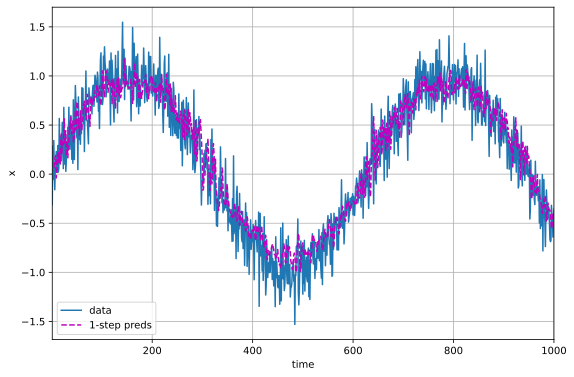

In [71]:
"""
由于训练损失很小，因此我们期望模型能有很好的工作效果。 让我们看看这在实践中意味着什么。

首先是检查模型预测下一个时间步的能力， 也就是单步预测（one-step-ahead prediction）。
"""
onestep_preds = net(features)
d2l.plot([time,time[tau:]],[x.detach().numpy(),onestep_preds.detach().numpy()],'time','x',legend=['data','1-step preds'],xlim=[1,1000],figsize=(9,6))


正如我们所料，单步预测效果不错。即使这些预测的时间步超过了$600+4$（`n_train + tau`），其结果看起来仍然是可信的。然而有一个小问题：如果数据观察序列的时间步只到$604$，我们需要一步一步地向前迈进：
$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

通常，对于直到$x_t$的观测序列，其在时间步$t+k$处的预测输出$\hat{x}_{t+k}$称为$k$*步预测*（$k$-step-ahead-prediction）。由于我们的观察已经到了$x_{604}$，它的$k$步预测是$\hat{x}_{604+k}$。换句话说，我们必须使用我们自己的预测（而不是原始数据）来**进行多步预测**。让我们看看效果如何。

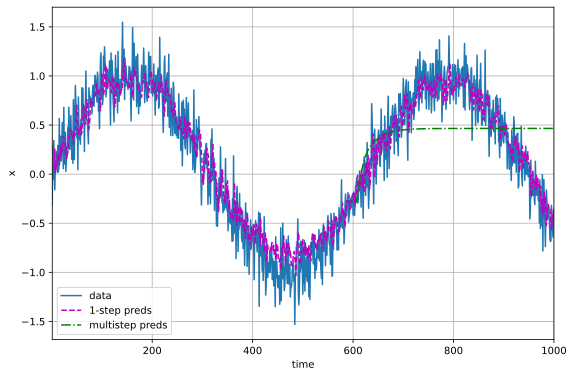

In [65]:
multistep_preds=torch.zeros(T)
multistep_preds[:n_train+tau]=x[:n_train+tau]
for i in range(n_train+tau,T):
    multistep_preds[i]=net(multistep_preds[i-tau:i].reshape((1,-1)))

d2l.plot([time,time[tau:],time[n_train+tau:]],[x.detach().numpy(),onestep_preds.detach().numpy(),multistep_preds[n_train+tau:].detach().numpy()],'time','x',legend=['data','1-step preds','multistep preds'],xlim=[1,1000],figsize=(9,6))

如上面的例子所示，**绿线的预测**显然并不理想。经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。为什么这个算法效果这么差呢？事实是由于错误的累积：假设在步骤$1$之后，我们积累了一些错误$\epsilon_1 = \bar\epsilon$。于是，步骤$2$的输入被扰动了$\epsilon_1$，结果积累的误差是依照次序的$\epsilon_2 = \bar\epsilon + c \epsilon_1$，其中$c$为某个常数，后面的预测误差依此类推。因此误差可能会相当快地偏离真实的观测结果。例如，未来$24$小时的天气预报往往相当准确，但超过这一点，精度就会迅速下降。我们将在本章及后续章节中讨论如何改进这一点。

基于$k = 1, 4, 16, 64$，通过对整个序列预测的计算，让我们**更仔细地看一下$k$步预测**的困难。

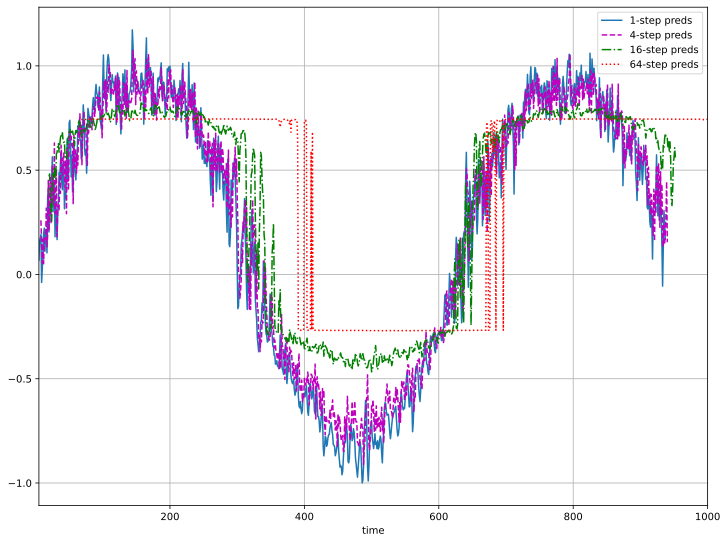

In [72]:
"""
下面展示当我们试图预测更远的未来时，预测的质量是如何变化的。
虽然“步预测”看起来仍然不错，但超过这个跨度的任何预测几乎都是无用的。
"""

max_steps=64

features=torch.zeros((T-tau-max_steps+1,tau+max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:,i]=x[i:i+T-tau-max_steps+1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau,tau+max_steps):
    features[:,i]=net(features[:,i-tau:i]).reshape(-1)

steps=(1,4,16,64)

d2l.plot([time[tau+i-1:T-max_steps+i] for i in steps ],
         [features[:,(tau+i-1)].detach().numpy() for i in steps],
         'time',
         legend=[f'{i}-step preds' for i in steps],
         xlim=[5,1000],
         figsize=(12,9)
         )


## 8.1.4. 小结
- 时序模型中，当前数据跟之前观察到的数据相关
- **内插法**（在现有观测值之间进行估计）和**外推法**（对超出已知观测范围进行预测）在实践的难度上差别很大。因此，对于你所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进行训练。
- 序列模型的估计需要专门的统计工具，两种较流行的选择是**自回归模型**和**隐变量自回归模型**。
- 对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。
- 对于直到时间步t的观测序列，其在时间步t+k的预测输出是“k步预测”。随着我们对预测时间值k的增加，会造成误差的快速累积和预测质量的极速下降。